In [8]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Import librairies
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy

In [11]:
# Import files
import constants
from models.resnet18k import make_resnet18k
from training_utils import*

# 1. Data preprocessing

## 1.1 Load data

### 1.1.1 Normal version

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])
# -*- LOAD CIFAR 10 -*-

#Train Dataset
CIFAR_10_train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_10_test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

# -*- LOAD CIFAR 100 -*-

#Train Dataset
CIFAR_100_train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_100_test_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 1.1.2. Augmented version

In [13]:
transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# -*- LOAD CIFAR 10 -*-

#Train Dataset
CIFAR_10_train_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented)

#Test Dataset
CIFAR_10_test_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented)

# -*- LOAD CIFAR 100 -*-

#Train Dataset
CIFAR_100_train_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented)

#Test Dataset
CIFAR_100_test_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1.2 Create Dataloader

### 1.2.1 Normal version

In [14]:
CIFAR_10_train_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_10_train_dataset,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_10_test_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_10_test_dataset,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

CIFAR_100_train_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_100_train_dataset,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_100_test_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_100_test_dataset,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

### 1.2.2 Augmented version

In [15]:
def label_noise(dataset, noise_ratio=0.1, seed = 0):
    np.random.seed(seed)

    # Make a deep copy of the dataset
    noisy_dataset = copy.deepcopy(dataset)

    total_images = len(noisy_dataset)

    num_noisy_images = int(total_images * noise_ratio)

    indices = np.random.choice(total_images, num_noisy_images, replace=False)

    num_classes = len(np.unique(noisy_dataset.targets))

    for idx in indices:
        noisy_dataset.targets[idx] = torch.randint(0, num_classes, (1,))

    return noisy_dataset

In [16]:
CIFAR_10_train_dataloader_aug = torch.utils.data.DataLoader(
    dataset=CIFAR_10_train_dataset_aug,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_10_test_dataloader_aug = torch.utils.data.DataLoader(
    dataset=CIFAR_10_test_dataset_aug,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

CIFAR_100_train_dataloader_aug = torch.utils.data.DataLoader(
    dataset=CIFAR_100_train_dataset_aug,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_100_test_dataloader_aug = torch.utils.data.DataLoader(
    dataset=CIFAR_100_test_dataset_aug,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

## 1.3 Vizualize the Dataset

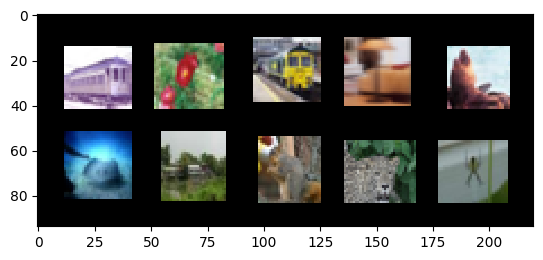

In [18]:
images = next(iter(CIFAR_100_train_dataloader_aug))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

# 2. Produce Figure 4

## 2.1 CIFAR 10

In [ ]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0,0.1,0.2]

train_losses = []
test_losses = []
accuracies = []
for noise_ratio in noise_ratio_list:
    print(f'Predicting with noise ratio {noise_ratio}')
    noisy_train_dataset = label_noise(CIFAR_10_train_dataset_aug, noise_ratio=noise_ratio)
    noisy_train_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_train_dataset,
        batch_size=constants.BATCH_SIZE,
        shuffle=True,
        num_workers=2)
    noisy_test_dataset = label_noise(CIFAR_10_test_dataset_aug, noise_ratio=noise_ratio)
    noisy_test_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_test_dataset,
        batch_size=constants.TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2)
    
    for width in width_model_list:
        print(f'Predicting with width {width}')
        ResNet = make_resnet18k(k=width)
        cnn = ResNet.to(constants.DEVICE)
        optimizer = torch.optim.SGD(cnn.parameters(), lr=constants.Adam_LR)
        losses = fit(
            model=cnn,
            train_dataloader=CIFAR_10_train_dataloader,
            optimizer=optimizer,
            epochs=2,
            device=constants.DEVICE
        )
        test_loss, acc = predict(model=cnn, test_dataloader=noisy_train_dataloader, device=constants.DEVICE)
        train_losses.append(losses)
        test_losses.append(test_loss)
        accuracies.append(acc)

Predicting with noise ratio 0
Predicting with width 1


KeyboardInterrupt: 

## 2.2 CIFAR 100

In [19]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0,0.1,0.2]

train_losses = []
test_losses = []
accuracies = []
for noise_ratio in noise_ratio_list:
    print(f'Predicting with noise ratio {noise_ratio}')
    noisy_train_dataset = label_noise(CIFAR_100_train_dataset_aug, noise_ratio=noise_ratio)
    noisy_train_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_train_dataset,
        batch_size=constants.BATCH_SIZE,
        shuffle=True,
        num_workers=2)
    noisy_test_dataset = label_noise(CIFAR_100_test_dataset_aug, noise_ratio=noise_ratio)
    noisy_test_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_test_dataset,
        batch_size=constants.TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2)
    
    for width in width_model_list:
        print(f'Predicting with width {width}')
        ResNet = make_resnet18k(k=width)
        cnn = ResNet.to(constants.DEVICE)
        optimizer = torch.optim.SGD(cnn.parameters(), lr=constants.Adam_LR)
        losses = fit(
            model=cnn,
            train_dataloader=CIFAR_10_train_dataloader,
            optimizer=optimizer,
            epochs=2,
            device=constants.DEVICE
        )
        test_loss, acc = predict(model=cnn, test_dataloader=noisy_train_dataloader, device=constants.DEVICE)
        train_losses.append(losses)
        test_losses.append(test_loss)
        accuracies.append(acc)

Predicting with noise ratio 0
Predicting with width 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x110338680>
Traceback (most recent call last):
  File "/Users/vincentroduit/.pyenv/versions/3.11.6/envs/Machine-Learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/vincentroduit/.pyenv/versions/3.11.6/envs/Machine-Learning/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 